In [1]:
import spacy
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import numpy as np
import IPython
#from daterangeparser import parse
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_sm')  # Load a pre-trained English pipeline

In [2]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1a84f66bc50>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1a85041ab70>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1a8503bb4c0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1a850723a50>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1a850723050>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1a8506c40b0>)]

#### Extracting Events and Dates from News Articles

In [3]:
#Loading BBC News Data

df_bbc_data = pd.read_csv("bbc_news.csv")

print(f'Shape of data: {df_bbc_data.shape}')
# Show top 5 records
df_bbc_data.head()

Shape of data: (42115, 5)


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [4]:
#Data Information

df_bbc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        42115 non-null  object
 1   pubDate      42115 non-null  object
 2   guid         42115 non-null  object
 3   link         42115 non-null  object
 4   description  42115 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [5]:
#Convert date column to right data type and remove old date column
df_bbc_data['pubDate'] = pd.to_datetime(df_bbc_data['pubDate'])
df_bbc_data['date'] = df_bbc_data['pubDate'].dt.date
df_bbc_data = df_bbc_data.drop('pubDate', axis=1)
df_bbc_data.head()

,title,guid,link,description,date
0,Ukraine: Angry Zelensky vows to punish Russian...,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,2022-03-07
1,War in Ukraine: Taking cover in a town under a...,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",2022-03-06
2,Ukraine war 'catastrophic for global food',https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,2022-03-07
3,Manchester Arena bombing: Saffie Roussos's par...,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,2022-03-07
4,Ukraine conflict: Oil price soars to highest l...,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,2022-03-07


In [6]:
#Take a sample of the data and keep and copy and use that copy for further processing and analysis
df = df_bbc_data.sample(n=1000).copy()

Oldest Date: 2022-03-06
Newest Date: 2024-12-02


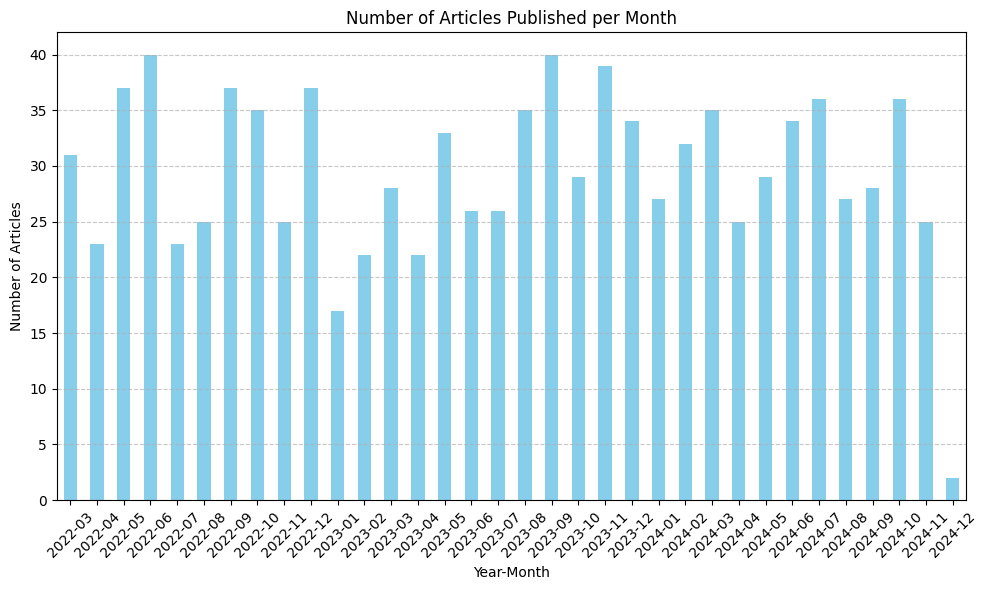

In [7]:

# Convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")

# Function to analyze dates
def analyze_dates(df, date_col):
    # Find oldest and newest dates
    oldest_date = df[date_col].min()
    newest_date = df[date_col].max()
    print(f"Oldest Date: {oldest_date.date()}")
    print(f"Newest Date: {newest_date.date()}")

    # Create a new column for Year-Month
    df["year_month"] = df[date_col].dt.to_period("M")

    # Group by Year-Month to count articles per month
    density = df.groupby("year_month").size()

    # Plot the density as a bar graph
    density.plot(kind="bar", figsize=(10, 6), color="skyblue")
    plt.title("Number of Articles Published per Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function
analyze_dates(df, "date")


In [8]:
df.head()

,title,guid,link,description,date,year_month
2422,Post office: Workers at 114 branches strike ov...,https://www.bbc.co.uk/news/business-61300417,https://www.bbc.co.uk/news/business-61300417?a...,The Crown Post Offices will close for 24 hours...,2022-05-02,2022-05
20996,Police officer rescues child and adult from se...,https://www.bbc.co.uk/news/uk-england-essex-66...,https://www.bbc.co.uk/news/uk-england-essex-66...,Two people had got into difficulties in the wa...,2023-08-20,2023-08
11529,Serbian leader holds security talks over Kosov...,https://www.bbc.co.uk/news/world-europe-63936840,https://www.bbc.co.uk/news/world-europe-639368...,Longstanding tensions between Kosovo's authori...,2022-12-11,2022-12
39632,Skripals will not give evidence at Salisbury p...,https://www.bbc.com/news/articles/cn0erdydx0go#4,https://www.bbc.com/news/articles/cn0erdydx0go,A judge has ruled that Sergei and Yulia Skripa...,2024-09-29,2024-09
21749,Sara Sharif: Dad and stepmum release video in ...,https://www.bbc.co.uk/news/uk-66726936,https://www.bbc.co.uk/news/uk-66726936?at_medi...,Urfan Sharif and his partner describe Sara's d...,2023-09-06,2023-09


In [9]:
df = df.drop(['date'], axis=1)
df

,title,guid,link,description,year_month
2422,Post office: Workers at 114 branches strike ov...,https://www.bbc.co.uk/news/business-61300417,https://www.bbc.co.uk/news/business-61300417?a...,The Crown Post Offices will close for 24 hours...,2022-05
20996,Police officer rescues child and adult from se...,https://www.bbc.co.uk/news/uk-england-essex-66...,https://www.bbc.co.uk/news/uk-england-essex-66...,Two people had got into difficulties in the wa...,2023-08
11529,Serbian leader holds security talks over Kosov...,https://www.bbc.co.uk/news/world-europe-63936840,https://www.bbc.co.uk/news/world-europe-639368...,Longstanding tensions between Kosovo's authori...,2022-12
39632,Skripals will not give evidence at Salisbury p...,https://www.bbc.com/news/articles/cn0erdydx0go#4,https://www.bbc.com/news/articles/cn0erdydx0go,A judge has ruled that Sergei and Yulia Skripa...,2024-09
21749,Sara Sharif: Dad and stepmum release video in ...,https://www.bbc.co.uk/news/uk-66726936,https://www.bbc.co.uk/news/uk-66726936?at_medi...,Urfan Sharif and his partner describe Sara's d...,2023-09
...,...,...,...,...,...
22151,Luton Town: Garth Crooks' comments are 'disres...,https://www.bbc.co.uk/sport/football/66812514,https://www.bbc.co.uk/sport/football/66812514?...,BBC pundit Garth Crooks tipping newly-promoted...,2023-09
21089,Edinburgh Fringe: Can TikTok comedy stars cut ...,https://www.bbc.co.uk/news/entertainment-arts-...,https://www.bbc.co.uk/news/entertainment-arts-...,"They have millions of followers, but can they ...",2023-08
14027,"Asylum claims for 12,000 to be considered with...",https://www.bbc.co.uk/news/uk-64736123,https://www.bbc.co.uk/news/uk-64736123?at_medi...,The Home Office is to scrap face-to-face inter...,2023-02
27629,Rafael Nadal: Why Spanish great will be so mis...,https://www.bbc.co.uk/sport/tennis/67498075,https://www.bbc.co.uk/sport/tennis/67498075?at...,As Rafael Nadal withdraws from this year's Aus...,2024-01


In [10]:
# Conditions
year_pattern = r'\b([1-9][0-9]{3})\b'  # Matches any 4-digit year from 1000 onward
month_pattern = r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b'
day_pattern = r'\b(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)\b'
currency_pattern = r'[\$\€\₹]\d+|\d+[\$\€\₹]'  # Matches numbers with currency symbols

# Function to filter rows
def filter_rows(df, column):
    filtered_rows = df[column].apply(
        lambda x: (
            bool(re.search(year_pattern, x)) or  # Matches years
            bool(re.search(month_pattern, x, re.IGNORECASE)) or  # Matches months
            bool(re.search(day_pattern, x, re.IGNORECASE))  # Matches days
        ) and not bool(re.search(currency_pattern, x))  # Excludes currency-related rows
    )
    return df[filtered_rows]

# Apply filtering
filtered_df = filter_rows(df, "description")

filtered_df

,title,guid,link,description,year_month
20996,Police officer rescues child and adult from se...,https://www.bbc.co.uk/news/uk-england-essex-66...,https://www.bbc.co.uk/news/uk-england-essex-66...,Two people had got into difficulties in the wa...,2023-08
25735,Sir Rod Stewart to sell items from his Essex h...,https://www.bbc.co.uk/news/uk-england-essex-67...,https://www.bbc.co.uk/news/uk-england-essex-67...,Auctioneer director John Black says it is goin...,2023-11
39928,Paedophile head may have abused over four decades,https://www.bbc.com/news/articles/czd1jy23177o#0,https://www.bbc.com/news/articles/czd1jy23177o,Neil Foden may have offended for more than 40 ...,2024-10
32742,'I watch my back': Spike in BBC journalists li...,https://www.bbc.co.uk/news/world-68929462#4,https://www.bbc.co.uk/news/world-68929462,The number of BBC World Service journalists wo...,2024-05
40740,"What is a 'working person', according to Labour?",https://www.bbc.com/news/articles/cwyg44lwjydo#1,https://www.bbc.com/news/articles/cwyg44lwjydo,The government has promised not to raise taxes...,2024-10
...,...,...,...,...,...
30158,'Devastated' dog theft victim let down over law,https://www.bbc.co.uk/news/uk-wales-68448497#7,https://www.bbc.co.uk/news/uk-wales-68448497,"Carwyn Powell's sheepdog went missing in 2018,...",2024-03
18830,Cat Stevens soothes an exhausted Glastonbury i...,https://www.bbc.co.uk/news/entertainment-arts-...,https://www.bbc.co.uk/news/entertainment-arts-...,"The folk star plays a laid-back, hit-heavy set...",2023-06
32807,Hainault sword attack victim thanks NHS for sa...,https://www.bbc.co.uk/news/uk-england-london-6...,https://www.bbc.co.uk/news/uk-england-london-6...,Henry De Los Rios Polania sustained a deep wou...,2024-05
31549,What is happening to energy bills?,https://www.bbc.co.uk/news/business-58090533#8,https://www.bbc.co.uk/news/business-58090533,A new energy price cap means the cost of elect...,2024-04


In [11]:
filtered_df.to_csv('Dates_events.csv')

In [12]:
def extract_named_entities(text):
    doc = nlp(text)
    entities = [{"entity": ent.text, "label": ent.label_} for ent in doc.ents]
    return entities
  

In [13]:
# Apply the function to the dataframe
df['named_entities'] = df['description'].apply(extract_named_entities)

df

,title,guid,link,description,year_month,named_entities
2422,Post office: Workers at 114 branches strike ov...,https://www.bbc.co.uk/news/business-61300417,https://www.bbc.co.uk/news/business-61300417?a...,The Crown Post Offices will close for 24 hours...,2022-05,"[{'entity': 'The Crown Post Offices', 'label':..."
20996,Police officer rescues child and adult from se...,https://www.bbc.co.uk/news/uk-england-essex-66...,https://www.bbc.co.uk/news/uk-england-essex-66...,Two people had got into difficulties in the wa...,2023-08,"[{'entity': 'Two', 'label': 'CARDINAL'}, {'ent..."
11529,Serbian leader holds security talks over Kosov...,https://www.bbc.co.uk/news/world-europe-63936840,https://www.bbc.co.uk/news/world-europe-639368...,Longstanding tensions between Kosovo's authori...,2022-12,"[{'entity': 'Kosovo', 'label': 'GPE'}, {'entit..."
39632,Skripals will not give evidence at Salisbury p...,https://www.bbc.com/news/articles/cn0erdydx0go#4,https://www.bbc.com/news/articles/cn0erdydx0go,A judge has ruled that Sergei and Yulia Skripa...,2024-09,"[{'entity': 'Sergei', 'label': 'PERSON'}, {'en..."
21749,Sara Sharif: Dad and stepmum release video in ...,https://www.bbc.co.uk/news/uk-66726936,https://www.bbc.co.uk/news/uk-66726936?at_medi...,Urfan Sharif and his partner describe Sara's d...,2023-09,"[{'entity': 'Urfan Sharif', 'label': 'PERSON'}..."
...,...,...,...,...,...,...
22151,Luton Town: Garth Crooks' comments are 'disres...,https://www.bbc.co.uk/sport/football/66812514,https://www.bbc.co.uk/sport/football/66812514?...,BBC pundit Garth Crooks tipping newly-promoted...,2023-09,"[{'entity': 'BBC', 'label': 'ORG'}, {'entity':..."
21089,Edinburgh Fringe: Can TikTok comedy stars cut ...,https://www.bbc.co.uk/news/entertainment-arts-...,https://www.bbc.co.uk/news/entertainment-arts-...,"They have millions of followers, but can they ...",2023-08,"[{'entity': 'millions', 'label': 'CARDINAL'}, ..."
14027,"Asylum claims for 12,000 to be considered with...",https://www.bbc.co.uk/news/uk-64736123,https://www.bbc.co.uk/news/uk-64736123?at_medi...,The Home Office is to scrap face-to-face inter...,2023-02,"[{'entity': 'The Home Office', 'label': 'ORG'}..."
27629,Rafael Nadal: Why Spanish great will be so mis...,https://www.bbc.co.uk/sport/tennis/67498075,https://www.bbc.co.uk/sport/tennis/67498075?at...,As Rafael Nadal withdraws from this year's Aus...,2024-01,"[{'entity': 'Rafael Nadal', 'label': 'PERSON'}..."


In [14]:
def dates(text):
    doc = nlp(text)
    dates = [ent.text for ent in filter(lambda e: e.label_ == 'DATE', doc.ents)]
    return dates

df['extracted_dates'] = df['description'].apply(extract_named_entities)

df

,title,guid,link,description,year_month,named_entities,extracted_dates
2422,Post office: Workers at 114 branches strike ov...,https://www.bbc.co.uk/news/business-61300417,https://www.bbc.co.uk/news/business-61300417?a...,The Crown Post Offices will close for 24 hours...,2022-05,"[{'entity': 'The Crown Post Offices', 'label':...","[{'entity': 'The Crown Post Offices', 'label':..."
20996,Police officer rescues child and adult from se...,https://www.bbc.co.uk/news/uk-england-essex-66...,https://www.bbc.co.uk/news/uk-england-essex-66...,Two people had got into difficulties in the wa...,2023-08,"[{'entity': 'Two', 'label': 'CARDINAL'}, {'ent...","[{'entity': 'Two', 'label': 'CARDINAL'}, {'ent..."
11529,Serbian leader holds security talks over Kosov...,https://www.bbc.co.uk/news/world-europe-63936840,https://www.bbc.co.uk/news/world-europe-639368...,Longstanding tensions between Kosovo's authori...,2022-12,"[{'entity': 'Kosovo', 'label': 'GPE'}, {'entit...","[{'entity': 'Kosovo', 'label': 'GPE'}, {'entit..."
39632,Skripals will not give evidence at Salisbury p...,https://www.bbc.com/news/articles/cn0erdydx0go#4,https://www.bbc.com/news/articles/cn0erdydx0go,A judge has ruled that Sergei and Yulia Skripa...,2024-09,"[{'entity': 'Sergei', 'label': 'PERSON'}, {'en...","[{'entity': 'Sergei', 'label': 'PERSON'}, {'en..."
21749,Sara Sharif: Dad and stepmum release video in ...,https://www.bbc.co.uk/news/uk-66726936,https://www.bbc.co.uk/news/uk-66726936?at_medi...,Urfan Sharif and his partner describe Sara's d...,2023-09,"[{'entity': 'Urfan Sharif', 'label': 'PERSON'}...","[{'entity': 'Urfan Sharif', 'label': 'PERSON'}..."
...,...,...,...,...,...,...,...
22151,Luton Town: Garth Crooks' comments are 'disres...,https://www.bbc.co.uk/sport/football/66812514,https://www.bbc.co.uk/sport/football/66812514?...,BBC pundit Garth Crooks tipping newly-promoted...,2023-09,"[{'entity': 'BBC', 'label': 'ORG'}, {'entity':...","[{'entity': 'BBC', 'label': 'ORG'}, {'entity':..."
21089,Edinburgh Fringe: Can TikTok comedy stars cut ...,https://www.bbc.co.uk/news/entertainment-arts-...,https://www.bbc.co.uk/news/entertainment-arts-...,"They have millions of followers, but can they ...",2023-08,"[{'entity': 'millions', 'label': 'CARDINAL'}, ...","[{'entity': 'millions', 'label': 'CARDINAL'}, ..."
14027,"Asylum claims for 12,000 to be considered with...",https://www.bbc.co.uk/news/uk-64736123,https://www.bbc.co.uk/news/uk-64736123?at_medi...,The Home Office is to scrap face-to-face inter...,2023-02,"[{'entity': 'The Home Office', 'label': 'ORG'}...","[{'entity': 'The Home Office', 'label': 'ORG'}..."
27629,Rafael Nadal: Why Spanish great will be so mis...,https://www.bbc.co.uk/sport/tennis/67498075,https://www.bbc.co.uk/sport/tennis/67498075?at...,As Rafael Nadal withdraws from this year's Aus...,2024-01,"[{'entity': 'Rafael Nadal', 'label': 'PERSON'}...","[{'entity': 'Rafael Nadal', 'label': 'PERSON'}..."


In [26]:
df.to_csv('dates_and_entities.csv')

#### Extracting Customer and Transaction Information from Business Emails

In [15]:
pd.options.mode.chained_assignment = None

chunk = pd.read_csv('emails.csv', chunksize=500)
data = next(chunk)

data.info()
print(data.message[2])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     500 non-null    object
 1   message  500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB
Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>
Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
From: phillip.allen@enron.com
To: leah.arsdall@enron.com
Subject: Re: test
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Leah Van Arsdall
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

test successful.  way to go!!!


In [16]:
data = pd.read_csv('emails.csv')
print(data.head())

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [17]:
data.shape

(517401, 2)

In [18]:
data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [19]:
#Take a sample of the data for ease of analysis
data = data.sample(n=1000).copy()

In [20]:
data.message

331839    Message-ID: <14143435.1075860791821.JavaMail.e...
450628    Message-ID: <11567859.1075842194735.JavaMail.e...
249996    Message-ID: <3847482.1075846365644.JavaMail.ev...
491855    Message-ID: <714950.1075851847584.JavaMail.eva...
263222    Message-ID: <21565312.1075857749657.JavaMail.e...
                                ...                        
436803    Message-ID: <4999233.1075858722607.JavaMail.ev...
141988    Message-ID: <30842635.1075849655899.JavaMail.e...
364618    Message-ID: <28407621.1075841430944.JavaMail.e...
344639    Message-ID: <18427802.1075842613593.JavaMail.e...
80694     Message-ID: <891489.1075843833645.JavaMail.eva...
Name: message, Length: 1000, dtype: object

In [21]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract relevant details
def extract_email_details(email_text):
    details = {}
    
    # Extract sender email
    sender_match = re.search(r"From: ([\w\.-]+@[\w\.-]+)", email_text)
    details["Sender Email"] = sender_match.group(1) if sender_match else None
    
    # Extract recipient email
    recipient_match = re.search(r"To: ([\w\.-]+@[\w\.-]+)", email_text)
    details["Recipient Email"] = recipient_match.group(1) if recipient_match else None
    
    # Extract subject
    subject_match = re.search(r"Subject: (.+)", email_text)
    details["Subject"] = subject_match.group(1).strip() if subject_match else None
    
    # Extract date
    date_match = re.search(r"Date: (.+)", email_text)
    details["Date"] = date_match.group(1).strip() if date_match else None
    
    # Parse text for additional details
    doc = nlp(email_text)
    
    # Extract names from the text
    names = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    details["Names in Text"] = ", ".join(names)
    
    # Extract dates from the text
    dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
    details["Dates in Text"] = ", ".join(dates)
    
    # Extract names from the text
    geopolitical_entity = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    details["GPEs in Text"] = ", ".join(geopolitical_entity)
    
    # Extract names from the text
    Organization = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    details["ORGs in Text"] = ", ".join(Organization)
    
    # Extract names from the text
    Events = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]
    details["Events in Text"] = ", ".join(Events)
    
    return details


In [22]:
# Apply extraction function
data_extracted = data["message"].apply(extract_email_details)

# Convert to DataFrame
data_extracted = pd.DataFrame(data_extracted.tolist())



In [23]:
data_extracted

,Sender Email,Recipient Email,Subject,Date,Names in Text,Dates in Text,GPEs in Text,ORGs in Text,Events in Text
0,clarissa.garcia@enron.com,scott.neal@enron.com,FW: CGT - Capacity Auctions,"Tue, 26 Feb 2002 07:07:40 -0800 (PST)","Garcia, Clarissa, Neal, Scott, Jonathan, Judy,...","26 Feb 2002, Tuesday, February 26, 2002, FEBRU...","Mckay, Mainline, Rayne, Louisiana, Leach, Kent...","jonathan.mckay@enron.com, f..brawner@enron.com...",
1,carol.clair@enron.com,carolyn.george@enron.com,My Time,"Fri, 25 May 2001 05:10:00 -0700 (PDT)","Carol St Clair, Carolyn George\nX-cc, Suzanne ...","25 May 2001, this week, Tuesday, Friday",,"Mime-Version, Content-Type, Content-Transfer-E...",
2,joe.hillings@enron.com,david.haug@enron.com,Re: AREAS OF RESPONSIBILITY,"Thu, 17 Feb 2000 05:37:00 -0800 (PST)","Joe Hillings, David Haug\nX-cc, Stephen D Burn...",17 Feb 2000,,"Content-Type, Content-Transfer-Encoding, Enron",
3,mnolan@houston.rr.com,kim.ward@enron.com,Where Do I Send the Check?,"Wed, 29 Nov 2000 05:31:00 -0800 (PST)","Michael Nolan, Kim, Mike","Wed,, last week, Sunday, Christmas",Houston,"PST, Mime-Version, Content-Type, Content-Trans...",Thanksgiving
4,john.lavorato@enron.com,kimberly.hillis@enron.com,Re: Nigel Patterson,"Fri, 29 Sep 2000 05:42:00 -0700 (PDT)","Nigel Patterson, John J Lavorato\nX-To, Kimber...",,,"Content-Type, Content-Transfer-Encoding, X-Ori...",
...,...,...,...,...,...,...,...,...,...
995,ginger.dernehl@enron.com,ginger.dernehl@enron.com,CHANGE: Conf. Call re:California Campaign Con...,"Fri, 19 Oct 2001 12:25:06 -0700 (PDT)","Dasovich, Jeff, Paul, Susan, Smara>, Richard, ...","Thursday, October 18, 2001 10:00 AM, Friday, O...","Conf, Kaufman, Mara, Noske, Mara, Noske, Conf","California Campaign Contributions\n, Mime-Vers...",
996,enron.announcements@enron.com,prc.distribution@enron.com,Follow-up to PRC EMail distributed on 12/27/00,"Fri, 5 Jan 2001 11:11:00 -0800 (PST)","Steve Kean, Cindy Olson","5 Jan 2001, December 27, 2000","PRC, PRC, PRC","Mime-Version, Content-Type, Content-Transfer-E...",
997,swoodworth@technologystaffing.com,kpresto@enron.com,HELP!,"Tue, 29 Jan 2002 15:15:03 -0800 (PST)","Stacie Woodworth, Kevin Presto, Kevin M.\Delet...",29 Jan 2002,Background,"Content-Type, Content-Transfer-Encoding, PE, P...",
998,lmarlatt@br-inc.com,gerald.nemec@enron.com,re: Lost Creek-ENA IT Agreement,"Wed, 13 Sep 2000 08:46:00 -0700 (PDT)","Lori Marlatt, Gerald, Lori, Paul Keeler, April...","2000, 713/624-9268",,"Content-Type, Content-Transfer-Encoding, X-Ori...",


In [35]:
data_extracted.to_csv('email_details.csv')

#### Legal Document Analysis for Entity and Relationship Extraction

In [24]:
legal_data = pd.read_csv('train_data.csv')
print(legal_data.head())

                                                text
0  THIS SUPPLEMENT AND JOINDER AGREEMENT (this Ag...
1  The Borrower, the Guarantors, the lenders part...
2  Pursuant to Section 2.14 of the Credit Agreeme...
3  (a)Additional Lender. By executing and deliver...
4  (iv) a certificate of the Chief Financial Offi...


In [25]:
legal_data.shape

(26539, 1)

In [26]:
legal_data.head()

,text
0,THIS SUPPLEMENT AND JOINDER AGREEMENT (this Ag...
1,"The Borrower, the Guarantors, the lenders part..."
2,Pursuant to Section 2.14 of the Credit Agreeme...
3,(a)Additional Lender. By executing and deliver...
4,(iv) a certificate of the Chief Financial Offi...


In [27]:
#Take a sample of the data for ease of analysis
legal_data = legal_data.sample(n=1000).copy()

In [28]:
# Preprocess text
legal_data['cleaned_text'] = legal_data['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
legal_data['cleaned_text'].head()

12785    Eurodollar Rate means for any Interest Period ...
26015    (v) from the date hereof to the Closing Date, ...
2403     (c) Effect; Assignment Effective Date. Upon (i...
7717     1. | The contracting parties entered into a Le...
11851    8.9 Governing Law. This Agreement and the othe...
Name: cleaned_text, dtype: object

In [29]:
# Add rule-based matching for legal sections
matcher = Matcher(nlp.vocab)
patterns = [{"label": "SECTION", "pattern": [{"LOWER": "section"}, {"IS_DIGIT": True}]}]
for pattern in patterns:
    matcher.add(pattern["label"], [pattern["pattern"]])

def extract_entities(doc):
    entities = {"PARTIES": [], "DATES": [], "SECTIONS": [], "REFERENCES": []}
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entities["PARTIES"].append(ent.text)
        elif ent.label_ == "DATE":
            entities["DATES"].append(ent.text)
        elif ent.label_ in ["ORG", "LAW"]:
            entities["REFERENCES"].append(ent.text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        entities["SECTIONS"].append(doc[start:end].text)
    return entities

In [30]:
legal_data['entities'] = legal_data['cleaned_text'].apply(lambda x: extract_entities(nlp(x)))
legal_data[['cleaned_text', 'entities']]

,cleaned_text,entities
12785,Eurodollar Rate means for any Interest Period ...,"{'PARTIES': [], 'DATES': ['the first day', 'th..."
26015,"(v) from the date hereof to the Closing Date, ...","{'PARTIES': [], 'DATES': [], 'SECTIONS': [], '..."
2403,(c) Effect; Assignment Effective Date. Upon (i...,"{'PARTIES': [], 'DATES': [], 'SECTIONS': [], '..."
7717,1. | The contracting parties entered into a Le...,"{'PARTIES': ['Helmut Qualtinger Gasse 2'], 'DA..."
11851,8.9 Governing Law. This Agreement and the othe...,"{'PARTIES': [], 'DATES': [], 'SECTIONS': [], '..."
...,...,...
10874,After any final judgment or award shall have b...,"{'PARTIES': [], 'DATES': [], 'SECTIONS': [], '..."
22827,4.2Restrictions on Transfer of Vested Shares.V...,"{'PARTIES': [], 'DATES': [], 'SECTIONS': [], '..."
14834,(a) all First Lien Obligations will be and are...,"{'PARTIES': ['Lien Obligations', 'Lien Debt', ..."
22079,10.2. | Landlords Consent: ---|--- Landlord sh...,"{'PARTIES': ['Landlord', 'Transfer', 'Lease', ..."


In [18]:
legal_data.to_csv('legal_entities.csv')

In [19]:
!pip install networkx pyvis


   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   --------------------------- ------------ 524.3/756.0 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 756.0/756.0 kB 3.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


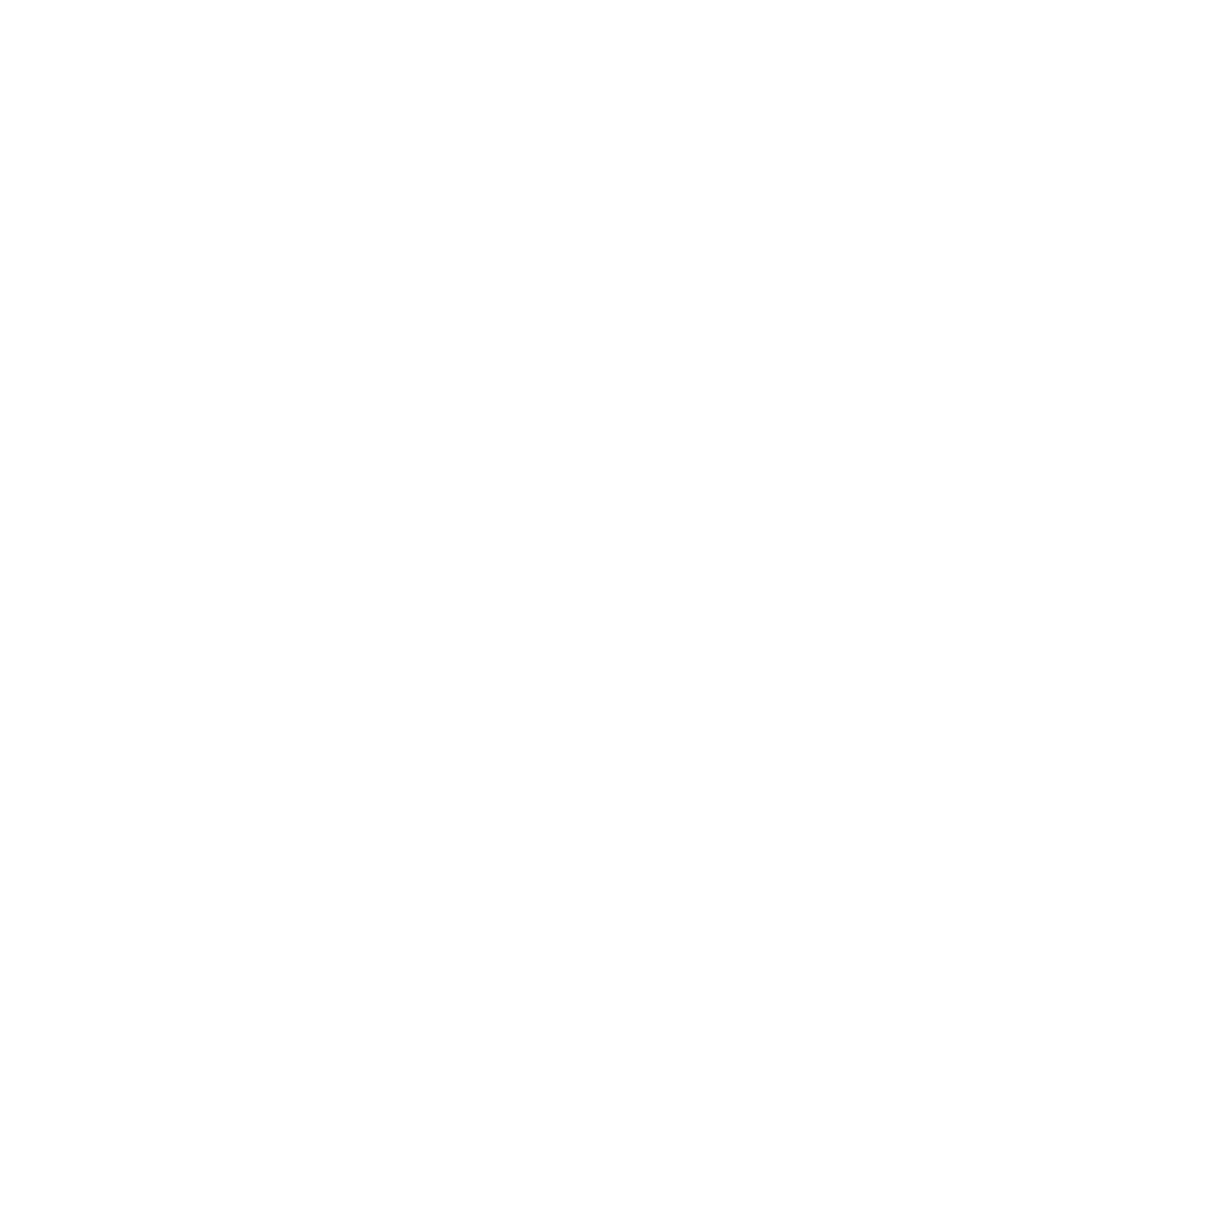

In [14]:
import networkx as nx

plt.figure(figsize=(12,12))
G = nx.Graph()
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [9]:
import networkx as nx
from pyvis.network import Network

# Create a graph
G = nx.Graph()

# Add nodes and edges
for idx, row in legal_data.iterrows():
    parties = row['entities']['PARTIES']
    references = row['entities']['REFERENCES']
    for party in parties:
        G.add_node(party, label='Party', color='blue')
    for ref in references:
        G.add_node(ref, label='Reference', color='green')
        for party in parties:
            G.add_edge(party, ref, label='Referenced In')

# Visualize the graph
net = Network(notebook=True)
net.from_nx(G)
net.show("knowledge_graph.html")


knowledge_graph.html


In [10]:
from pyvis.network import Network

# Create the PyVis Network graph
net = Network(notebook=True, cdn_resources="in_line")  # Use 'in_line' to embed resources

# Load the graph from NetworkX
net.from_nx(G)

# Save and display the graph
net.show("knowledge_graph.html")


knowledge_graph.html


In [11]:
from IPython.core.display import display, HTML
from IPython.display import IFrame

net.show("knowledge_graph.html")

# Embed in Jupyter Notebook
display(IFrame(src="knowledge_graph.html", width="100%", height="600"))


knowledge_graph.html


C:\Users\1508\AppData\Local\Temp\ipykernel_25072\2655607769.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [12]:
from pyvis.network import Network

# Create the PyVis Network graph
net = Network(notebook=False, cdn_resources="in_line")  # Disable notebook mode for external viewing

# Load the graph from NetworkX
net.from_nx(G)

# Optional: Add interactive buttons for graph options
net.show_buttons(filter_=['physics', 'nodes', 'edges'])

# Save the graph to an HTML file
net.show("knowledge_graph.html")

# Manually open in browser (if not auto-opened)
import webbrowser
webbrowser.open("knowledge_graph.html")


knowledge_graph.html


AttributeError: 'NoneType' object has no attribute 'render'

In [13]:
net = Network(notebook=True, cdn_resources="remote")
net.from_nx(G)
net.show("knowledge_graph.html")

knowledge_graph.html
